## Imports

In [100]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from copy import deepcopy

from math import pi, cos, sin, sqrt, tan, acos, asin
import numpy as np
from numpy import array, zeros, arange
from numpy import concatenate as np_concat
from numpy import real
from numpy.linalg import eig as eigenvalues
import matplotlib.pyplot as plt

from calculate_system import EquationCalculator
from progress_bar import ProgressBar
from create_fig import *
from function_root_finder import roots
from log_progress import log_progress

from collections import defaultdict



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [284]:
M = 2.0
c1 = 800.0
c0 = 1.0 * c1

beta = 0.1

r = 0.04
I = 2.0

b = 0.5  # engine
d = 0.01

# 3 DOF additions

m = M * 0.015

L = 1.2
gamma = pi / 6

beta1 = beta * 1.0
beta2 = beta * 0.7

c2 = c1 * 0.4
c3 = c1 * 0.4

# dimensionless max engine rotation velocity. 1 = resonance
engine_om_max = 2.5

In [285]:
def recalculate_supplementary_parameters(print_parameters=True, new_eps=0.1):
    global om_l, k, om, Lcos, k0, engine_om_max, a, OM_max, K_L, q, eps, K_, h1, \
           h, r_, mu, k2, k3, r_eps, h2, ro, Aw, Aw2, r_eps2, k2_, k3_, kw, kw_, ro_
        
    om_l = sqrt(c1 / M)
    k = c0 / c1
    om = sqrt(1 + k)

    Lcos = L * cos(gamma)
    k0 = k

    #

    engine_om_max_ = om * engine_om_max
    a = engine_om_max_ * (b - d) * om_l

    OM_max = a / b
    K_L = a / OM_max
    q = OM_max / om_l

    if print_parameters:
        print("om_l   = ", om_l)
        print("k      = ", k)
        print("om     = ", om)
        print("K_L    = ", K_L)
        print("OM_max = ", OM_max)
        print("q      = ", q)
        print("")

    eps = new_eps

    K_ = K_L / om_l / I / eps
    h1 = d / om_l / I / eps
    h = beta1 / om_l / M / eps
    r_ = r / eps

    mu = m / M / eps
    k2 = c2 / c1 / eps
    k3 = c3 / c1 / eps
    r_eps = r / Lcos / eps
    h2 = beta2 / M / om_l / eps**2

    ro = r_eps * M / I * Lcos**2

    if print_parameters:
        print("eps    = ", eps)
        print("K_L    = ", K_L)
        print("h      = ", h)
        print("h1     = ", h1)
        print("r_     = ", r_)

    Aw = (2.0 - 2.0 * cos(gamma)) ** 0.5 / eps
    Aw2 = Aw ** 2
    r_eps2 = r_eps / eps

    k2_ = k2 / cos(gamma)
    k3_ = k3 / cos(gamma)
    kw = (k2 + k3) * (1 - 1 / cos(gamma))  # kw + (k2+k3) / cos(gamma) * 1.5 * Aw2 * eps #
    kw_ = 2 * (k2 + k3) * (1 / cos(gamma) - 1)
    ro_ = ro * eps

    print("recalculate, engine om max = %f", engine_om_max_)

    if print_parameters:
        print("Aw     = ", Aw)

In [286]:
recalculate_supplementary_parameters(print_parameters=True, new_eps=0.1)

om_l   =  20.0
k      =  1.0
om     =  1.4142135623730951
K_L    =  0.5
OM_max =  69.29646455628166
q      =  3.464823227814083

eps    =  0.1
K_L    =  0.5
h      =  0.024999999999999998
h1     =  0.0025
r_     =  0.39999999999999997
recalculate, engine om max = %f 3.5355339059327378
Aw     =  3.3162790702970346


## Equations

2 Dof system equation

In [12]:
def initial_2_DOF(t, v):
    """
    F[0] = x
    F[1] = x'
    F[2] = fi
    F[3] = fi'
    """
    F = zeros(4)
    F[0] = v[1]
    F[1] = (-c1*(v[0]-r*sin(v[2])) - c0*v[0] - beta*v[1]) / M
    F[2] = v[3]
    F[3] = (K_L * (OM_max - v[3]) - d*v[3] + c1*r * (v[0] - r*sin(v[2])) * cos(v[2])) / I
    return F

2 Dof system with inclusion of small parameter

In [13]:
def initial_2_DOF_with_eps(t, v):
    """
    v[0] = x
    v[1] = x'
    v[2] = fi
    v[3] = fi'
    """
    F = zeros(4)
    F[0] = v[1]
    F[1] = -(om**2)*v[0] + eps * (r_*sin(v[2]) - h*v[1])
    F[2] = v[3]
    F[3] = eps * (K_ * (q - v[3]) - h1*v[3] + r_ * v[0] * cos(v[2]) * M/I) - (eps**2) * (r_**2 * 0.5 * sin(2.0 * v[2]) * M/I)
    return F

## 2 Dof system check

In [14]:
initial_eq = EquationCalculator(initial_2_DOF, [0, 0, 0, 0], method='rk5a', ignore_cache=True)
initial_eq.step_size /= om_l
initial_eq.caclulate()


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


In [15]:
initial_eps = EquationCalculator(initial_2_DOF_with_eps, [0, 0, 0, 0], method='rk5a', ignore_cache=True, time_scale=om_l)
initial_eps.caclulate()


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


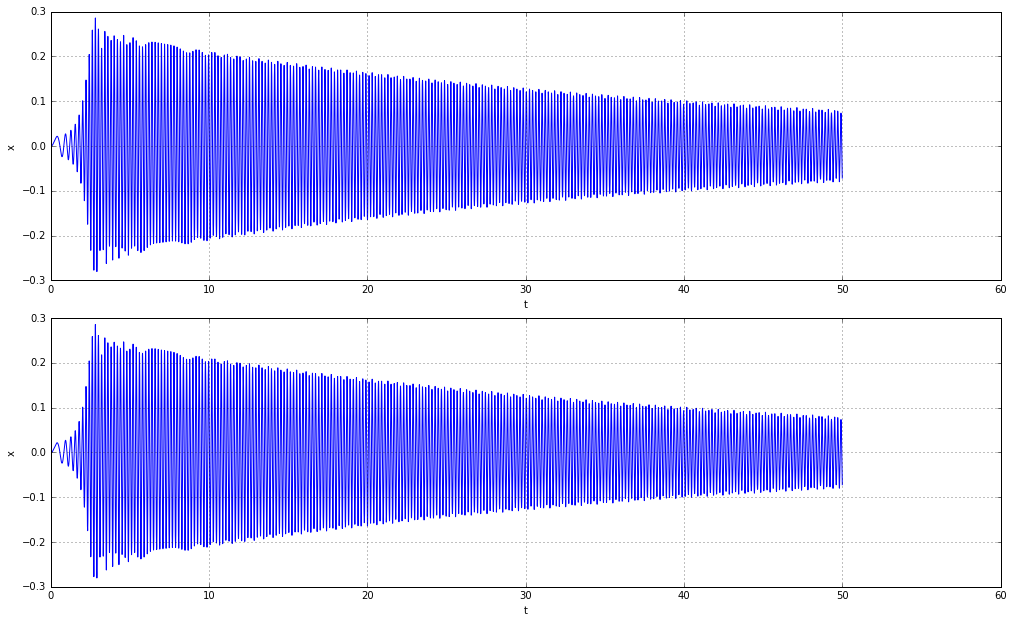

In [16]:
%matplotlib inline

fig = create_fig()
plots = add_subplots(fig, 2)

initial_eq.plot(plots[0], 't', '.t', 'x', '.v0', 'b-')
initial_eps.plot(plots[1], 't', '.t', 'x', '.v0', 'b-')

# First Resonance

In [318]:
q = 1.5

# def get_q(p0):
#     return p0 * (K_ + h1) / K_

print("K_", K_)
print("q", q)
print("h1", h1)
print("p0", p0)
print("mu = ", mu)
print("kw_", kw_)
print("om_w = ", (kw_ / mu) ** 0.5)
print("om_u = ", (1 + k0) ** 0.5)
print("delta = ", ((1 + k0) - p0**2) / eps)
print("D =", D)

print(get_q(2.0))

K_ 0.125
q 1.5
h1 0.0025
p0 3.63013202614
mu =  0.15
kw_ 0.9310115080686181
om_w =  2.491333656322276
om_u =  1.4142135623730951
delta =  -111.778585272
D = 0.369126985836
2.04


In [331]:

def get_1r_afc_0(p):
    A = (K_+h1) / 2.0
    B = K_*q / 2.0
    D = ro / 4.0
    delta = ((1 + k0) - p**2) / eps
    a2 = r_eps2 / 4 / D * (B - A*p) / (h*p + B - A*p) 
    a = a2**0.5
    return a
#     sin_b = 0.5*a*delta / (r_eps/4.0 - D*a2)
#     if sin_b is complex:
#         return -0.5
#     elif sin_b < 1.0 and sin_b > -1.0:
#         return a
#     else:
#         return 0





<IPython.core.display.Javascript object>


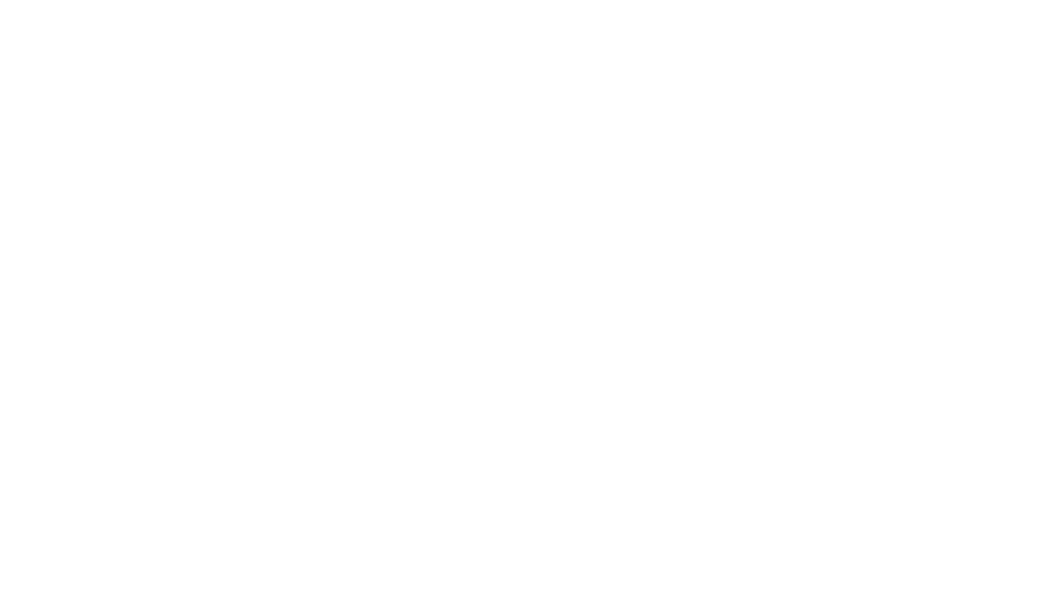

/Users/ordinec7/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


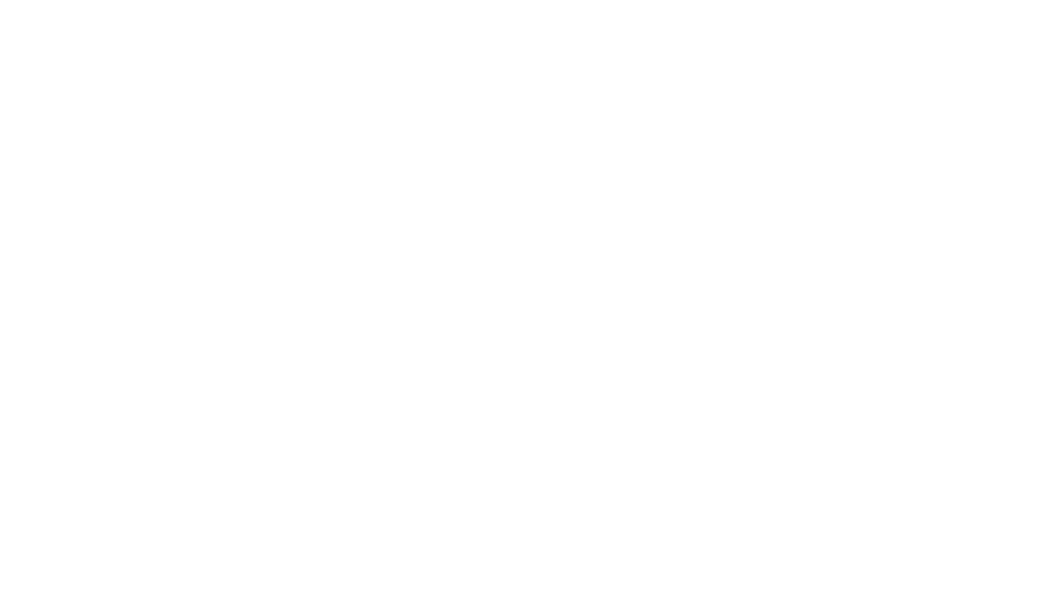

In [337]:
%matplotlib notebook

fig = create_fig()
plt.grid(b=True)

ps = arange(0.5, 2.0, 0.001)
xs = []
ys = []

for qi in [1.0, 1.5, 2.0, 2.5]:
    xs.append([])
    ys.append([])
    q = qi
    
    for pi in log_progress(ps):
        try:
            a = get_1r_afc_0(pi)
            if a > 0.01:
                xs[-1].append(pi)
                ys[-1].append(a)

        except TypeError:
            pass
    


# _as = [get_1r_afc(p) for p in ps]


# plt.plot(xs, ys, "bo", markeredgewidth=0.0, markersize=4)



In [273]:

def get_1r_afc():
    
    
    q = 1.4
    print("q = ", q)
    
    xs = []
    ys = []
    bs = []
    qs = []
    
    def eq(p):
        A = (K_+h1) / 2.0
        B = K_*q / 2.0
        D = ro_ / 4.0
        delta = ((1 + k0) - p**2) / eps
        
        def eq_a2(a2):
            return D**2 * a2**2 + a2 * 0.25 * (-(delta**2) - (h*p)**2 - 2*r_eps*D) + (r_eps/4.0)**2
        
        return roots(eq_a2, 0.0, 3.0, eps=1e-2)
    
    for qi in log_progress(arange(1.00, 2.00, 0.0001)):
        q = qi
        A = (K_+h1) / 2.0
        B = K_*q / 2.0
        D = ro_ / 4.0
        p = B/A
        delta = ((1 + k0) - p**2) / eps
        ns = eq(p)
        for ni in ns:
            a = ni**0.5
            sin_b = -a*delta/2.0 / (r_eps/4.0 - D * a**2)
            try:
                # print(sin_b)
                b = asin(sin_b)
                p2 = (B + 2*a*D*cos(b)) / A 
                xs.append(p2)
                ys.append(a)
                bs.append(b)
                qs.append(qi)
            except ValueError:
                pass
                

            
    return xs, ys, bs, qs


In [326]:

r1_ps, r1_as, r1_bs, r1_qs = get_1r_afc()


q =  1.4


(0.0, 2.5)

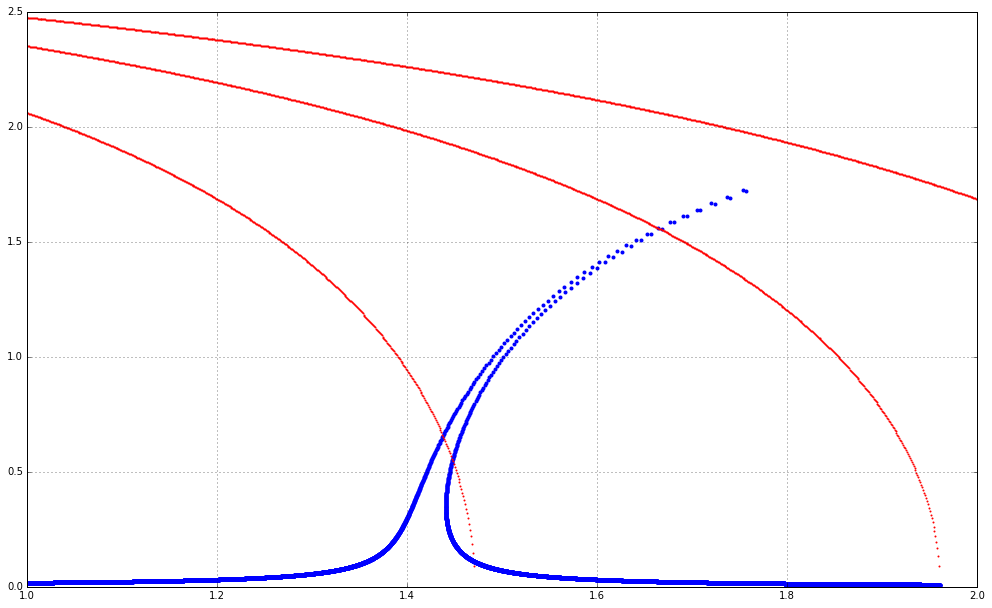

In [343]:
%matplotlib inline
fig = create_fig()
plt.grid(b=True)

plt.plot(r1_ps, r1_as, "bo", markeredgewidth=0.0, markersize=4)
for i in range(len(xs)):
    plt.plot(xs[i], ys[i], "ro", markeredgewidth=0.0, markersize=2)
    
plt.xlim([1.0, 2.0])
plt.ylim([0.0, 2.5])


In [275]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

def r1_stability(a0, p0, b0, qi):
    unknown_barier = 0.001
     
    q = qi
    A = (K_+h1) / 2.0
    B = K_*q / 2.0
    D = ro_ / 4.0
    delta = ((1 + k0) - p0**2) / eps
    
    mAA = -B/p0 + A - h/2 - cos(b0) * D * 2 * a0 / p0
    mAB = sin(b0) * (r_eps / 4.0 + D * a0**2) / p0
    mAP = a0 * (A - h/2)
    mBA = delta/2.0/a0/p0 - sin(b0)*D*2/p0
    mBB = cos(b0)*(r_eps/4 - D*a0**2)
    mBP = 0
    mPA = 2*D*cos(b0)
    mPB = -2*D*a0*sin(b0)
    mPP = -A
    
    matrix = array([[mAA, mAB, mAP], [mBA, mBB, mBP], [mPA, mPB, mPP]])

    w, v = eigenvalues(matrix)
    if all([abs(real(l)) < unknown_barier for l in w]):
        return UNKNOWN
    if all([real(l) < 0 for l in w]):
        return STABLE
    else:
        return UNSTABLE
    
r1s_xs = [[], [], []]
r2s_ys = [[], [], []]
#r1_ps, r1_as, r1_bs, r1_qs
for i in log_progress(range(len(r1_as))):
    st = r1_stability(r1_as[i], r1_ps[i], r1_bs[i], r1_qs[i])
    r1s_xs[st].append(r1_ps[i])
    r2s_ys[st].append(r1_as[i])
    

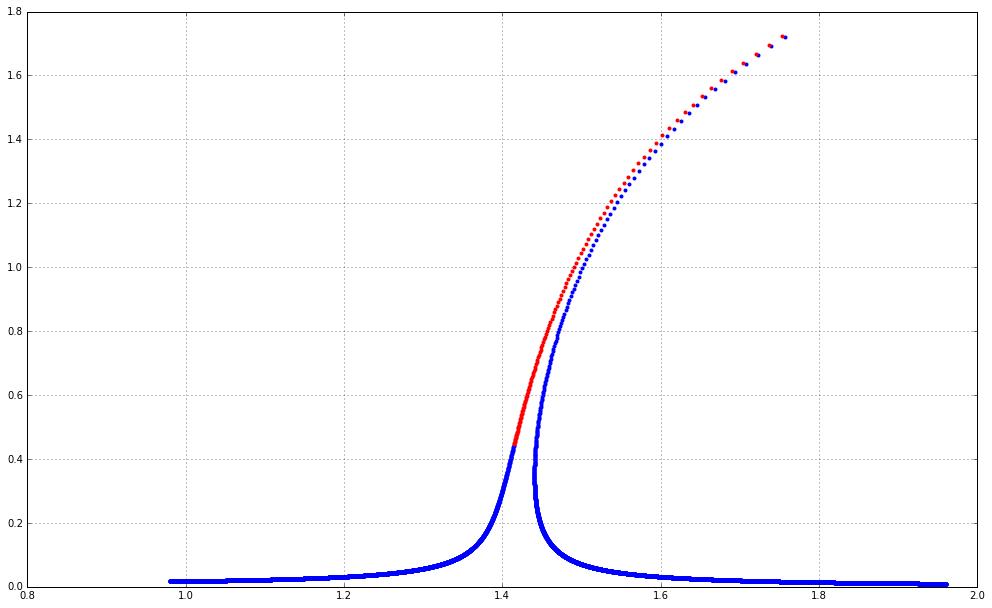

In [276]:
fig = create_fig()
plt.grid(b=True)

plt.plot(r1s_xs[STABLE], r2s_ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(r1s_xs[UNSTABLE], r2s_ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(r1s_xs[UNKNOWN], r2s_ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=6)

In [297]:
def r1_wA(a0, p0, b0, qi):
    q = qi
    om_w2 = (kw_ / mu)
    return a0 * Aw / (om_w2 - p0**2) * (k2_ + k2_) / 2 / mu * eps
    
r1_ws = []
r2_ps = []

for i in log_progress(range(len(r1_as))):
    w = r1_wA(r1_as[i], r1_ps[i], r1_bs[i], r1_qs[i])
    r1_ws.append(w)
    r2_ps.append(r1_ps[i])

In [298]:
k2_

4.2327528770171545

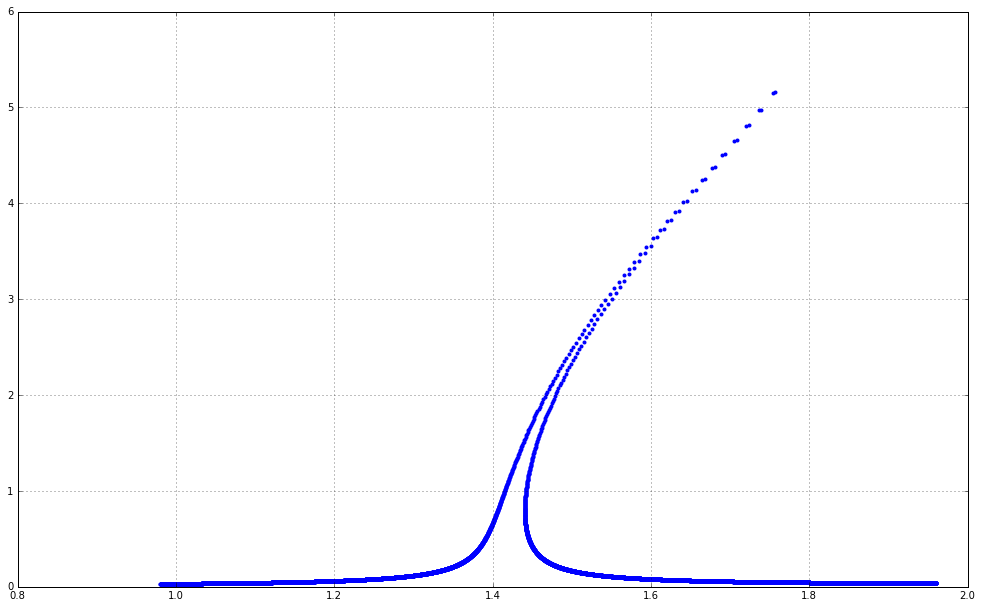

In [299]:
%matplotlib inline

fig = create_fig()
plt.grid(b=True)

plt.plot(r1_ps, r1_ws, "bo", markeredgewidth=0.0, markersize=4)

## 3DOF sysem stability and verification

# Stability try 3

In [288]:
def recalculate_stab_params():
    global p0, a0, D, D12, delta, k_a, om_w2, om_w
    p0 = K_*q / (K_ + h1)
    a0 = p0 * h2/mu/2.0
    D = k2_/8.0/mu * Aw * r_eps / (p0**2 - om**2)
    D12 = (D / a0)**2

    om_w2 = (kw_ / mu)
    om_w = om_w2 ** 0.5

    delta = (om_w2 - p0**2) / eps
    k_a = 3 * (k2_+k3_) / 4.0 / mu
    

recalculate_stab_params()

# for i in arange()
print("K_", K_)
print("q", q)
print("h1", h1)
print("p0", p0)
print("mu = ", mu)
print("kw_", kw_)
print("om_w = ", (kw_ / mu) ** 0.5)
print("delta = ", ((kw_ / mu) - p0**2) / eps)
print("D =", D)

def get_q(p0):
    return p0 * (K_ + h1) / K_


def get_qis(start, end, count, more=None, more_count=None):
    global qis
    step = (end - start) / count
    qis = arange(start, end, (end - start) / count)
    
    if more is not None:
        if more_count is None: more_count = 20
        qis = np_concat((
            qis, 
            arange(more - step*4, more + step*4, step*8.0 / (more_count*0.7)),  
            arange(more - step, more + step, step*2.0 / (more_count*0.3))
        ))
        
    return qis



K_ 0.125
q 3.464823227814083
h1 0.0025
p0 3.396885517464787
mu =  0.15
kw_ 0.9310115080686181
om_w =  2.491333656322276
delta =  -53.32087831637894
D = 0.43255291257741313


In [289]:
# satbility function
def f(n):
    return ((k_a*D12)**2 * (n**3)
            + delta*k_a*D12 * (n**2)
            + (0.25*delta**2 + a0**2) * n
            - a0**2)

# Stability 4

In [290]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

def stability4(a0, b0):
    
    treshhold = 0.001
    
    # a b equation
    def ab(t, v):
        """
        F[0] = a
        f[1] = b
        """
        a = v[0]
        b = v[1]
        F = zeros(2)
        F[0] = -a * h2/2.0/mu + D/p0 * cos(b)
        F[1] = 1/p0 * (0.5 * delta + k_a*a**2 - D/a * sin(b))
        return F

    
    def check_ab_stability(_a, _b):
        ab_check1 = EquationCalculator(ab, [_a * 1.01, _b * 1.01], method='rk5a', ignore_cache=True, t_end=100.0, pb=False, tolerance=1e-4, step_size=1e-2)
        ab_check1.caclulate()
            
        diff = (ab_check1.v[0][-1] - _a) ** 2 + (ab_check1.v[1][-1] - _b) ** 2
        
        if diff < treshhold:
            return STABLE
        else:
            return UNSTABLE

            
    b0s = [b0]#, b0+pi, b0+2*pi, b0-pi, b0-2*pi]
    
    if any([check_ab_stability(a0, bi) == STABLE for bi in b0s]):
        return STABLE
    else:
        return UNSTABLE


In [265]:
#preparation

xs4, ys4 = defaultdict(lambda: []), defaultdict(lambda: [])
max_y = 0


for qi in log_progress(get_qis(om_w - 0.6, om_w + 0.6, 600, get_q(3.6234), 50)):
    q = qi
    recalculate_stab_params()
    
    
    def f(n):
        return ((k_a*D12)**2 * (n**3)
                + delta*k_a*D12 * (n**2)
                + (0.25*delta**2 + a0**2) * n
                - a0**2)

    ns = roots(f, 0.0, 1.0, eps=1e-3)

    for n in ns:
        b = acos(n ** 0.5)
        a = (n ** 0.5) * (D / a0)
        st = stability4(a, b)

        ys4[st].append(a)
        xs4[st].append(p0)
        
        if st == STABLE:
            ys4[UNKNOWN].append(q)
        else:
            xs4[UNKNOWN].append(q)
        
        if max_y < a:
            max_y = a    

KeyboardInterrupt: 

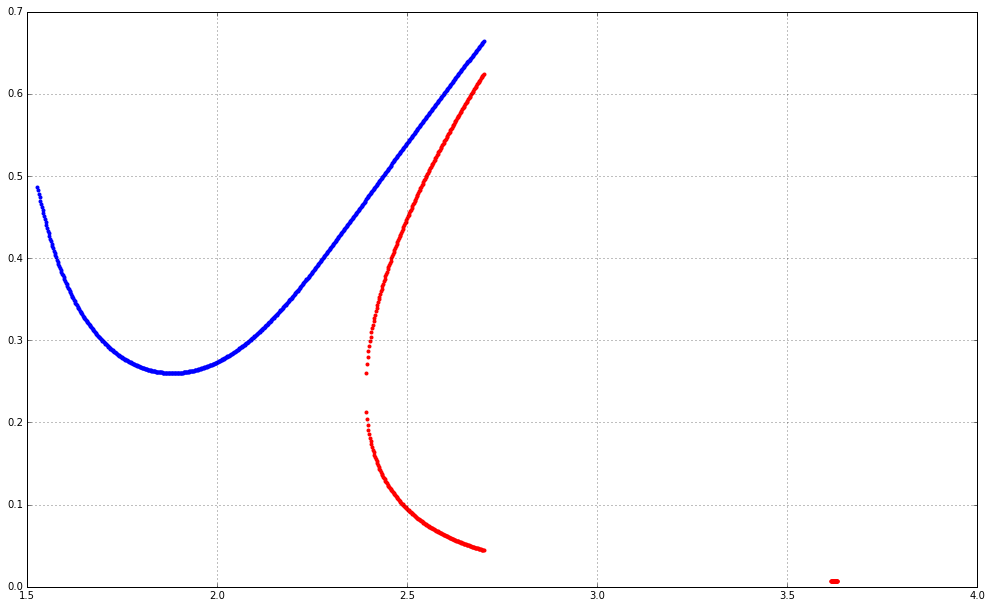

In [205]:

fig = create_fig()
plt.grid(b=True)

plt.plot(xs4[STABLE], ys4[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs4[UNSTABLE], ys4[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
# plt.plot(xs4[UNKNOWN], ys4[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)


In [206]:
# calculate field (optional)
field_y = arange(0.01, max_y + 0.01, 0.01)

xs42 = deepcopy(xs4)
ys42 = deepcopy(ys4)

cur_delta = None

for qi in log_progress(qis):

    q = qi + 0.005
    recalculate_stab_params()
    
    if cur_delta is None:
        cur_delta = delta
    elif abs(delta - cur_delta) < 1.0:
        continue
    else:
        cur_delta = delta
    
    for j in field_y:
        a = j
        
        try:
            b = acos(a / D * a0)
        except ValueError:
            break
            
        st = stability4(a, b)
        xs42[st].append(p0)
        ys42[st].append(a)

KeyboardInterrupt: 

In [ ]:

fig = create_fig()
plt.grid(b=True)

plt.plot(xs42[STABLE], ys42[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs42[UNSTABLE], ys42[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs4[STABLE], ys4[STABLE], "bo", markeredgewidth=0.0, markersize=6)
plt.plot(xs4[UNSTABLE], ys4[UNSTABLE], "ro", markeredgewidth=0.0, markersize=6)
# plt.plot(xs42[UNKNOWN], ys42[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

## Stability 5

In [291]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

unknown_barier = 0.00001

def stability5(a0, b0):
    def try_stabl(a0, b0):
        m00 = -h2/mu/2.0
        m01 = -a0/p0 * (delta / 2.0 + k_a*(a0**2))
        m10 = 1/a0/p0 * (delta / 2.0 + 3*k_a*(a0**2))
        m11 = -h2/mu/2.0
        matrix = array([[m00, m01], [m10, m11]])

        w, v = eigenvalues(matrix)
        if all([abs(real(l)) < unknown_barier for l in w]):
            return UNKNOWN
        if all([real(l) < 0 for l in w]):
            return STABLE
        else:
            return UNSTABLE
        
#     bxs = [(b0 + pi*x) for x in [0]]
#     results = [try_stabl(-a0, bx) for bx in bxs]

    results = [try_stabl(a0, b0)]
    
    if any([st == STABLE for st in results]):
        return STABLE
    elif any([st == UNKNOWN for st in results]):
        return UNKNOWN
    else:
        return UNSTABLE
    

In [305]:
#preparation

qis = get_qis(om_w - 0.6, om_w + 0.6, 600, get_q(3.6234), 100)
xs5, ys5 = [[], [], []], [[], [], []]
max_y = 0

def f2(a):
    return (a**3 * k_a**2
            + a**2 * delta*k_a
            + a * ((p0*h2/mu)**2 + delta**2) / 4.0
            - D ** 2)
            

# calculate stability

us = []
pus = []

pb_counter = 0
for qi in log_progress(qis):

    q = qi
    recalculate_stab_params()
    
    ns = roots(f2, 0.0, 4.0, eps=1e-3)

    for n in ns:            
        a = n ** 0.5
        b = acos(a * h2 * p0 / mu / 2.0 / D)
        
        u = a * Aw * k2_ * eps / (p0**2 - om_u)
        us.append(u)
        pus.append(p0)
        
        st = stability5(a, b)

        ys5[st].append(a)
        xs5[st].append(p0)
        
        if max_y < a:
            max_y = a    

In [306]:
# calculate field (optional)
field_y = arange(0.01, max_y + 0.1, 0.01)
# pb = ProgressBar("Stability field", 0, len(qis) - 1)
# pb_counter = 0

xs52 = deepcopy(xs5)
ys52 = deepcopy(ys5)

for qi in log_progress(qis, name="Field points"):
#     pb.setValue(pb_counter)
#     pb_counter += 1
    
    q = qi + 0.005
    recalculate_stab_params()
    
    for j in field_y:

        a = j
        try:
            b = acos(a / D * a0)
        except ValueError:
            continue
            
        st = stability5(a, b)
        xs52[st].append(p0)
        ys52[st].append(a)

(1.8, 3.0)

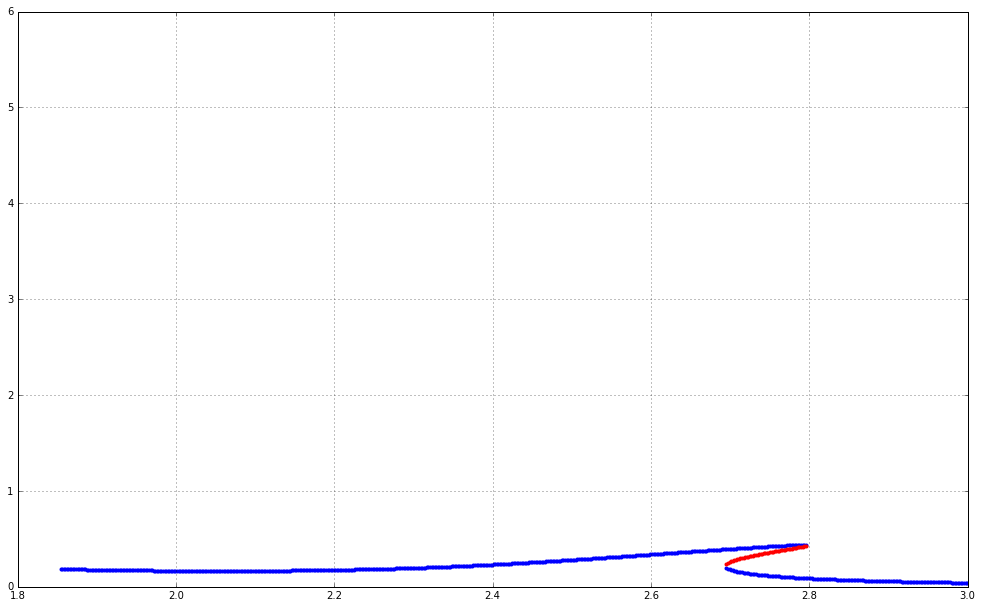

In [307]:


fig = create_fig()
plt.grid(b=True)

plt.plot(xs5[STABLE], ys5[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs5[UNSTABLE], ys5[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs5[UNKNOWN], ys5[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)
plt.ylim([0, 6.0])
plt.xlim([1.8, 3.0])

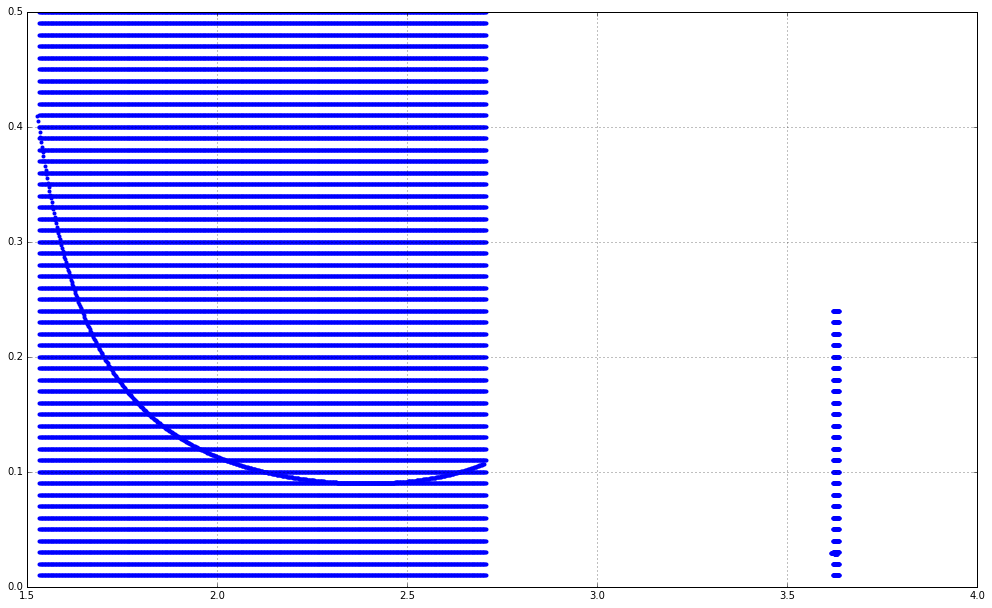

In [241]:

fig = create_fig()
plt.grid(b=True)

plt.plot(xs52[STABLE], ys52[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs52[UNSTABLE], ys52[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs52[UNKNOWN], ys52[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

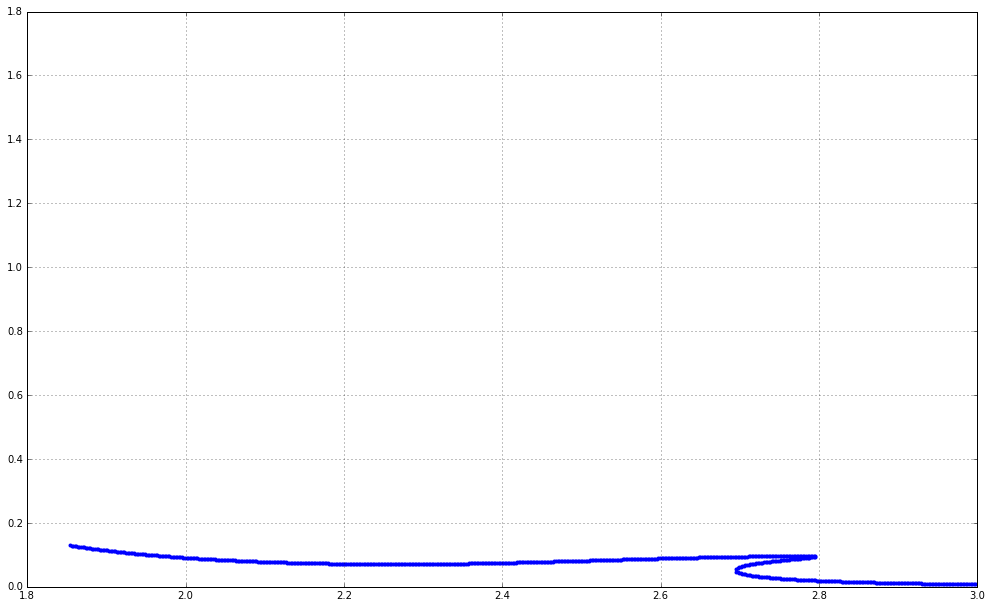

In [309]:

fig = create_fig()
plt.grid(b=True)

plt.ylim([0, 1.8])
plt.xlim([1.8, 3.0])
plt.plot(pus, us, "bo", markeredgewidth=0.0, markersize=4)

# Equations
Initial system equations

$\varphi = x_0^2 * a_{original}$

$M \ddot{x} + \beta_1 \dot{x} + (c_0 + c_1)\,x + c_2 \left[ \, 
    x - L \cos{\gamma} + L  \left( 
        1 + \dfrac{y^2}{ (L \cos{\gamma} - x)^2 } 
    \right)
\, \right] 
= c_1 r \sin{\varphi} $



